In [1]:
import sys
import numpy as np

class Node:
    def __init__(self, val, next_node=None):
        self.val = val
        self.next_node = next_node
        
class LinkedList:
    def __init__(self, head):
        self.head = head
        
def normalize(v):
    norm = np.linalg.norm(v)
    if norm == 0: 
        return v
    else:
        return v / norm

In [42]:
#!/usr/bin/env python
# coding: utf-8
%matplotlib inline
%reload_ext autoreload
%autoreload 
from IPython.display import HTML, display

sys.path.insert(0, '../')
from flightgoggles.env import *

# -- CONSTANT VARS ---
num_waypoints = 70
radius = 8
circle_center = [0, -10., -22.]

EPSILON = 2 * np.pi * radius * (0.085)
#2 * np.pi * radius / num_waypoints * 6 # how decide this??
OVERSHOOT = EPSILON #0.

LOOPS = 1
# -- END CONSTANT VARS -- 
string = "with rad {}, center at {}, num_waypoints {}, epsilon {:.2}, & overshoot {:.2}...".format(
    radius, circle_center, num_waypoints, EPSILON, OVERSHOOT)

theta = np.linspace(0, 2*np.pi * LOOPS, num_waypoints)

theta_perpen = theta + np.pi / 2
waypoint_coords = np.vstack((circle_center[0] + radius*np.cos(theta), #x
                             circle_center[1] + radius*np.sin(theta), #y
                             circle_center[2] * np.ones(num_waypoints), #z
                             theta_perpen))                                  # attitude

head = Node(waypoint_coords.T[0])
waypoint_ll = LinkedList(head)
p = head
for n in waypoint_coords.T:
    curr = Node(n)
    p.next_node = curr
    p = curr

if __name__ == "__main__":
    env = flightgoggles_env(
        cfg_dir="../config",
        cfg_fgclient="FlightGogglesClient_testing.yaml",
        cfg_uav="multicopterDynamicsSimSpeed.yaml") # 30 max_speed/accel multicopterDynamicsSimSpeed
    env.set_state_vehicle(vehicle_id="uav1", 
                          position = waypoint_ll.head.val[:3],
                          attitude_euler_angle=np.array([0., 0., theta_perpen[0]]))
    curr_pos = env.get_state("uav1")["position"]
    curr_att = env.get_state("uav1")["attitude_euler_angle"][2]
    curr_vel = env.get_state("uav1")["velocity"]

    att_accumulator = np.array([curr_att])
    pos_accumulator = np.array([curr_pos])
    
    curr_waypoint = waypoint_ll.head
    
    time_counter = 0
    crash = False
    while curr_waypoint:
        if (not curr_waypoint.next_node):
            EPSILON = 0.01
            OVERSHOOT = 0
        
        while np.linalg.norm(curr_pos - curr_waypoint.val[:3]) >= EPSILON:
            time_counter += 0.01
            curr_pos = env.get_state("uav1")["position"]
            curr_att = env.get_state("uav1")["attitude_euler_angle"][2]
            curr_vel = env.get_state("uav1")["velocity"]
            
            curr_pos_perpend_on_circle = radius * normalize(np.linalg.norm(circle_center - curr_pos)) + circle_center
            
            
            
            
            
            xy_vel = normalize(np.append(curr_vel, 0))
            xy_vel[2] = 0
                        
            collided = env.proceed_waypoint(vehicle_id="uav1",
                                            waypoint_command=curr_waypoint.val + xy_vel * OVERSHOOT,
                                            duration=0.01)
    
            att_accumulator = np.append(att_accumulator, curr_att)
            pos_accumulator = np.vstack((pos_accumulator, curr_pos))
            if collided:
                crash = True
                break
        if crash:
            print("CRASHED! :(")
            break
        
        curr_waypoint = curr_waypoint.next_node
    
    if not crash:
        f = open("observation notes circular.txt", "a")
        f.write(string + " it took {:.2f} sec\n".format(time_counter))
        f.close()
    
    with np.printoptions(precision=2, suppress=True):
        print("Final pose", np.append(env.get_state("uav1")["position"],
                                      env.get_state("uav1")["attitude_euler_angle"][2]))

    ani_set = env.plot_state_video(flag_save=False, filename="uav", dpi=300)
    if "cam1" in ani_set.keys():
        display(HTML(ani_set["cam1"].to_html5_video()))
    env.close()












Final pose [  8.    -9.99 -22.     1.56]


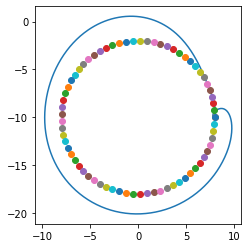

In [43]:
# Orange dots are the waypoints, dotted are waypoints
# coloration suggests the order
import itertools
import matplotlib.pyplot as plt

colors = itertools.cycle(['b', 'g', 'r', 'c', 'm', 'y', 'k'])

plt.gca().set_aspect('equal', adjustable='box')
plt.plot(pos_accumulator.T[0], pos_accumulator.T[1])
for column in waypoint_coords.T:
    plt.plot(column[0], column[1], 'o')

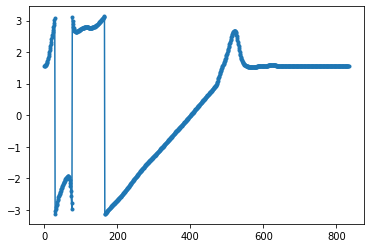

In [44]:
# import matplotlib.pyplot as plt
# x = np.arange(att_accumulator.size)
# y = att_accumulator
# #linear with a gap b/c pi to -pi
# plt.plot(x, y, marker='.')